<a href="https://colab.research.google.com/github/AbhiAadi/DeepONet/blob/main/NN_using_gstools_for_Double_Integral_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gstools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 25.0 MB/s eta 0:00:00


In [2]:
from gstools import SRF, Gaussian
from gstools.random import MasterRNG
from scipy import integrate

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.12.0
[]


In [3]:
m = 100 #sampling points for discretizing functions
p = 100  #points where output is measured
n = 150  #number of different functions

In [4]:
seed = MasterRNG(20170519)
def one_function(x):
    model = Gaussian(dim=1, var=2, len_scale=1)  #increase len_scale value to get smoother curves
    srf = SRF(model, seed=seed())
    f = srf.structured([x])
    return f

In [5]:
def integrate_one_function(f):
    result = np.zeros_like(f)
    result[0] = 0
    for i in range(1, len(f)):
        result[i] = integrate.simps(f[:i+1], x[:i+1])
    return result

In [6]:
def derivative_one_function(f, x):
  return np.gradient(f, x)

In [7]:
x = np.linspace(0, 1, m)

U = np.zeros((m, n))
for i in range(m):
    U[:, i] = one_function(x)

# U = np.zeros((m,n))
# for i in range(m):
#   U[:, i ] = np.sin(x)

In [8]:
S = np.zeros((m, n))
for i in range(n):
    S[:, i] =  integrate_one_function(integrate_one_function(U[:, i]))

In [9]:
# for i in range(n):
#    plt.plot(x, U[:, :i], color = 'b')
#    plt.plot(x, S[:, :i], color = 'r')
#    plt.show()

In [10]:
def interate_dataset(m=m, n=n , p=p, x=x, U=U, S=S):
    us = np.zeros((p*n, m))
    xs = np.zeros((p*n, 1))
    ss = np.zeros((p*n, 1))
    for i in range(n):
        for j in range(p):
            us[i*m+j, :] = U[:, i]
            xs[i*m+j, :] = x[j]
            ss[i*m+j, :] = S[j, i]
    return us, xs, ss

us, xs, ss = interate_dataset()
us.shape, xs.shape, ss.shape

((15000, 100), (15000, 1), (15000, 1))

In [11]:
ratio=0.8
train_size = int(len(us)*ratio)
us_train = us[:train_size]
xs_train = xs[:train_size]
ss_train = ss[:train_size]

us_test = us[train_size:]
xs_test = xs[train_size:]
ss_test = ss[train_size:]

us_train = np.hstack((us_train, xs_train))
us_test = np.hstack((us_test, xs_test))

us_train.shape,xs_train.shape,ss_train.shape,us_test.shape,xs_test.shape,ss_test.shape

((12000, 101), (12000, 1), (12000, 1), (3000, 101), (3000, 1), (3000, 1))

In [12]:
def deeponet_model(number_sensor_point, layer_branch, nodes_branch, output_size, activation_branch):
  # Creating branch net
  branch_input = tf.keras.layers.Input(shape = (number_sensor_point+1,), name = 'branch_input')

  branch_layers = []
  x = branch_input
  for i in range(layer_branch -1):
      layer_name = f'branch_{i+1}'
      x = tf.keras.layers.Dense(nodes_branch, activation=activation_branch, name=layer_name)(x)
      branch_layers.append(x)
  branch_output = tf.keras.layers.Dense(output_size, name = 'branch_output')(x)

  branch_net = tf.keras.models.Model(inputs = branch_input, outputs = branch_output)


  deeponet_model = tf.keras.models.Model(inputs=[branch_input], outputs=branch_output)

  return deeponet_model


In [13]:
number_sensor_point = m
layer_branch = 4
nodes_branch = 100
output_size = 1
activation_branch = 'relu'

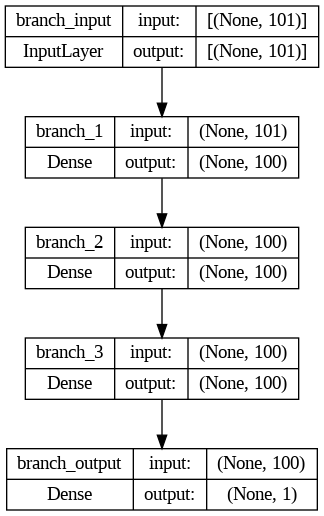

In [14]:
model = deeponet_model(number_sensor_point, layer_branch, nodes_branch, output_size, activation_branch)
tf.keras.utils.plot_model(model,show_shapes=True)

In [34]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 1e-4)

model.compile(optimizer = 'adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
losses = model.fit([us_train],ss_train,epochs=1000,batch_size=32,validation_data=([us_test],ss_test))


Epoch 1/1000
375/375 [==============================] - 1s 2ms/step - loss: 4.2502e-04 - root_mean_squared_error: 0.0206 - val_loss: 3.0416e-06 - val_root_mean_squared_error: 0.0017
Epoch 2/1000
375/375 [==============================] - 1s 1ms/step - loss: 1.9924e-04 - root_mean_squared_error: 0.0141 - val_loss: 3.2868e-06 - val_root_mean_squared_error: 0.0018
Epoch 3/1000
375/375 [==============================] - 1s 2ms/step - loss: 3.8153e-04 - root_mean_squared_error: 0.0195 - val_loss: 9.1140e-07 - val_root_mean_squared_error: 9.5467e-04
Epoch 4/1000
375/375 [==============================] - 1s 2ms/step - loss: 1.3214e-04 - root_mean_squared_error: 0.0115 - val_loss: 2.4083e-06 - val_root_mean_squared_error: 0.0016
Epoch 5/1000
375/375 [==============================] - 1s 2ms/step - loss: 2.6456e-04 - root_mean_squared_error: 0.0163 - val_loss: 6.6751e-06 - val_root_mean_squared_error: 0.0026
Epoch 6/1000
375/375 [==============================] - 1s 2ms/step - loss: 8.6615e-04

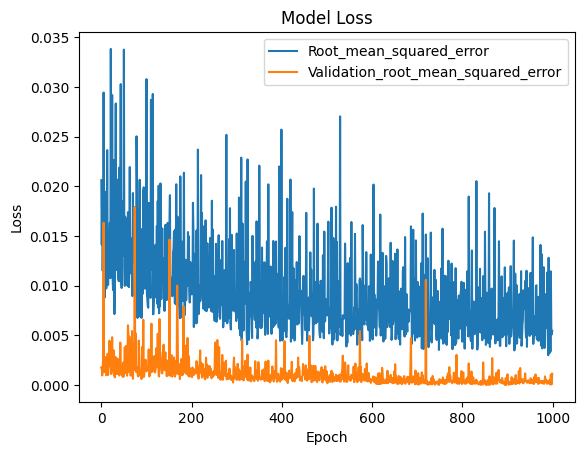

In [35]:
plt.plot(losses.history['root_mean_squared_error'], label='Root_mean_squared_error')
plt.plot(losses.history['val_root_mean_squared_error'], label='Validation_root_mean_squared_error')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(100,)


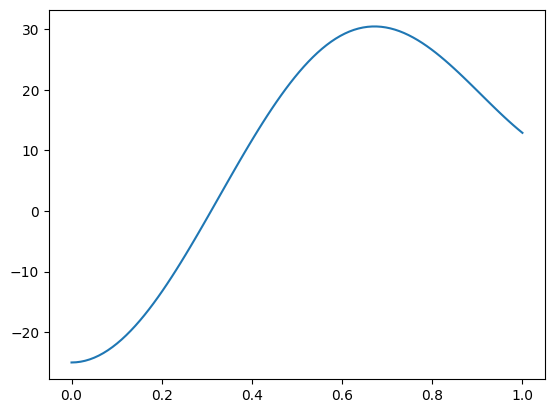

In [36]:
p =100

outp_loc = np.linspace(0,1,p)
my_func = lambda x: 20*x**3 -25*np.cos(5*x)
inter = lambda x:  x**5 + np.cos(5*x)
u_t = my_func(x)
s_t = inter(outp_loc)
print(u_t.shape)
plt.plot(x,u_t)
plt.show()

In [37]:
dm = []
dm1=[]
dm2=[]
for i in range(p):
  dm.append(u_t)
  j = outp_loc[i]
  dm2.append([j])
  dm1.append([s_t[i]])

inp_func = np.asarray(dm)
outp_func = np.asarray(dm1) #output function
y = np.asarray(dm2)
inp_func = np.hstack((inp_func, y))
print(outp_func.shape)
print(y.shape)
print(inp_func.shape)

(100, 1)
(100, 1)
(100, 101)


4/4 [==============================] - 0s 2ms/step


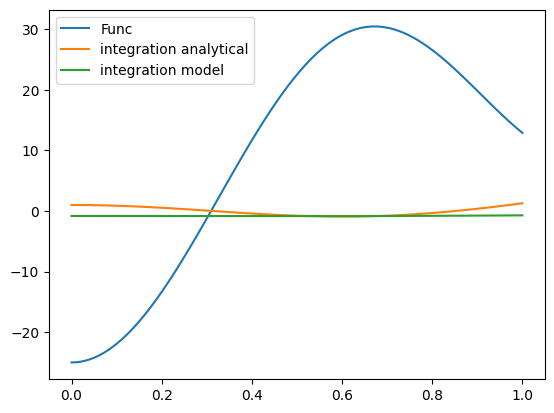

In [38]:
pt = model.predict([inp_func])

plt.plot(x, u_t, label="Func")
plt.plot(x, s_t, label="integration analytical")
plt.plot(x, pt, label="integration model")
plt.legend();